# Erstes Neuronales Netzwerk

Bevor wir das Netzwerk trainieren, müssen wir als Erstes unsere Libraries und Funktionen laden.

In [1]:
import numpy as np
from matplotlib import pyplot as plt # neben Numpy laden wir auch eine Funktion der Libary matplotlib -> sie ermöglicht es Graphen in Python zu erstellen
%matplotlib inline 


### Aktiverungsfunktionen


In [64]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) # np.exp() = e^()

def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

### One-hot encoding

Wir wollen die Labels nicht als einfache Zahl, sondern als Vektor aus Nullen und Einsen haben. Siehe unten:<br>
<center>
0  =  [1 0 0 0 0 0 0 0 0 0]<br>
1  =  [0 1 0 0 0 0 0 0 0 0]<br>
2  =  [0 0 1 0 0 0 0 0 0 0]<br>
3  =  [0 0 0 1 0 0 0 0 0 0]<br>
4  =  [0 0 0 0 1 0 0 0 0 0]<br>
5  =  [0 0 0 0 0 1 0 0 0 0]<br>
usw. <br>
9  =  [0 0 0 0 0 0 0 0 0 1]<br>
</center>

Die Funktion `one-hot` macht genau das.

In [3]:
def one_hot(x):
    """Die Labels der Bilder müssen noch in Vektoren von Länge 10 codiert werden"""
    dod = len(set(x)) # Checkt wie viele verschieden Ziffern es im Datennsatz gibt
    target = np.zeros([x.shape[0], dod]) # Eine Matrix aus Nullen wird erstellt
    for i in range(x.shape[0]): # Der for-loop setzt eine 1 in die Matrix abhängig davon welches Label das Bild hat
        target[i, x[i]] = 1

    return target

In [4]:
# Skaliert die originalen Bilder, die Werte zwischen 0 und 255 haben können, zu Bildern mit Werten zwischen 0 und 1.
# Neuronale Netzwerke können besser trainiert werden
def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### Daten einlesen

Wir können mit Numpy ohne Probleme die benötigten Daten einlesen. Die Trainingsdaten `mnist_train.csv` enthalten Bilder und deren Labels. Die Bilder sind schon von einer Matrix in einen Vektor transformiert worden.<br>
<center>
<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png" style="width: 800px;">
</center>

Der Datensatz kann auch extern angeschaut werden. Dafür klicken Sie einfach in der linken Spalte (je nach Jupyter Version) auf den Ordner `data` und danach auf die Datei `mnist_train.csv`. Die erste Spalte des jeweiligen Datensatzes enthält die Labels. In jeder Reihe ist ein Bild, zudem ist jeder Spalte (bis auf der ersten) ein Pixel zugeordnet.

Mit `np.genfromtxt()` lassen sich aus .txt-Datein Arrays in Python erstellen. 

In [7]:
train_data = np.genfromtxt('../data/mnist/mnist_train.csv', delimiter=',', skip_header =False) #genfromtxt liest .txt Datein, mit delimiter ="," können auch .csv (comma seperated values) Datein einglesen werden  
test_data=np.genfromtxt('../data/mnist/mnist_test.csv', delimiter=',', skip_header =False) # hier lesen wir die Test Daten ein

# Nach dem wir die Daten einglesen haben, trennen wir die Daten noch in Bilder und Labels
# Des Weiteren konvertieren wir Labels von Float zu Integer mit .astype(int)
train_labels=train_data[:,0].astype(int) 
train_images = train_data[:,1:]

test_labels=test_data[:,0].astype(int)
test_images = test_data[:,1:]

Wir haben jetzt den Trainingsdatensatz eingelesen. Sie können mit `train_images.shape` sehen, dass die Variable `train_images` eine 60000 x 784 Matrix ist, also 60000 Reihen und 784 Spalten hat. Jede Reihe ist ein Bild und jede Spalte ist ein Pixel. Die originalen Bilder waren 28 x 28 Pixel groß. Im nächsten Schritt benutzen wir die *Funktion* `one_hot`, um die Labels richtig zu codieren.

In [8]:
train_images.shape

(60000, 784)

In [9]:
train_targets=one_hot(train_labels)
test_targets = one_hot(test_labels)

train_targets[:5,:] # die Labels der ersten fünf Bilder

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Als letzten Schritt müssen wir noch den `min_max` Scaler benutzen, um die Pixelwerte zwischen Null und Eins zu skalieren.

In [56]:
train_images = min_max(train_images)
test_images = min_max(test_images)

In der folgenden Zelle können Sie ein Beispielbild sehen. Die Funktion `.reshape([28,28])` transformiert das Bild in seine ursprüngliche Version zurück. So kann man das Bild auch wirklich erkennen.

Correct Label: 5


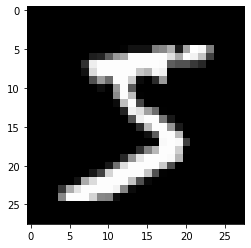

In [10]:
plt.imshow(train_images[0].reshape([28, 28]), cmap="gray")
print("Correct Label: %s" % train_labels[0])

### Das Model


**Weights Initalisieren** <br>
Als Erstes müssen die Weight und Bias Matrizen/Vektoren mit den richtigen Dimensionen erstellt werden. Dafür wird eine Funktion geschrieben. In ihr muss man die Größe der jeweiligen Layer (`input_size`, `hidden_size`, `output_size`) festlegen. Mit diesen können Sie die Weightmatrizen erstellen. Während die `b`- Vektoren mit Nullen gefüllt werden können, müssen die Weightmatrizen mit zufälligen kleinen Zahl initialisiert werden.

Die Funktion `np.random.randn(number_of_rows, number_of_columns)` setzt zufällige Werte zwischen minus Eins und plus Eins in die Matrix ein. Zusätzlich wird der Term`* np.sqrt(2/layer_size)` hinzugefügt. Dieser verkleinert die Werte noch weiter und soll damit ein besseres Trainieren des Netzwerkes garantieren. 

Im folgenden Code sollen Sie die richtigen Matrixgrößen (Anzahl der Reihen/Spalten) eintragen. Die Inputmatrix `X` hat 60000 Reihen und 784 Spalten und bei einer Matrixmultiplikation müssen die Anzahl der Spalten der ersten Matrix mit der Anzahl der Reihen der zweiten Matrix übereinstimmen.
Denken Sie auch daran, dass wir das Transpose der Weightmatrix benutzen werden.

Den Bias `b` wird mit Nullen initialisiert. `np.zeros(500)` würde ein Vektor der Länge 500 mit Nullen füllen.
Auch brauchen wir nicht die tatsächlichen Zahlen, sondern nur die Namen der Inputvariablen nennen,  also nicht 784, sondern `input_size`.
Die  tatsächlichen Werte können dann bei der eigentlichen Benutzung der Funktion definiert werden.

In [11]:
# Funktion zur intialisierung der Weights
def init_weights(input_size, hidden_size, output_size):
    # Zwei leere Listen mit Länge zwei
    b = [0] * 2
    W = [0] * 2

    # hier werden die Weights W mit kleinen, zufälligen Gewichten initialisiert
    
    W[0] = np.random.randn(        ,         ) * np.sqrt(2 / input_size)  # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN
    W[1] = np.random.randn(        ,         ) * np.sqrt(2 / hidden_size) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN

    # der bias kann 0 sein
    b[0] = np.zeros(       ) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN
    b[1] = np.zeros(       ) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN


    return W, b

SyntaxError: invalid syntax (4013193955.py, line 9)

<details>
<summary><strong>Lösung:</strong></summary>

```python
def init_weights(input_size, hidden_size, output_size):
    # Zwei leere Listen mit Länge zwei
    b = [0] * 2
    W = [0] * 2

    # hier werden die Weights W mit kleinen, zufälligen Gewichten initialisiert
    
    W[0] = np.random.randn(hidden_size,input_size) * np.sqrt(2 / input_size)  
    W[1] = np.random.randn(output_size,hidden_size) * np.sqrt(2 / hidden_size) 

    # der bias kann 0 sein
    b[0] = np.zeros(hidden_size) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN
    b[1] = np.zeros(output_size) # HIER MÜSSEN DIE RICHTIGEN GRÖßEN ANGEGBEN WERDEN


    return W, b
```
</details>

Die Weights können jetzt initialisiert werden: 

Die Inputgröße ist vorgegeben, da 784 Pixel in jedem Bild sind. Auch die Outputgröße ist vorgegeben, da das Netzwerk zwischen 10 verschiedene Ziffern unterscheiden muss.
Der einzige Wert, den Sie selber bestimmen können, ist die Größe der Hidden-Layer. Es gibt keine einfache Regel für die Größe, aber wenn sie zu klein ist, kann das die Genauigkeit des neuronalen Netzwerkes verringern. Wenn sie zu groß ist, trainiert das Netzwerk zu langsam und wird eventuell instabil. Auch das kann die Genauigkeit beeinflussen. Probieren Sie am Anfang Werte wie 100 oder 200 aus. 

Grundsätzliche werden Zahlen wie die Größe der Hidden-Layer oder die Lernrate, die Sie frei wählen können, als **Hyperparameter** bezeichnet. 

Mit dieser Funktion können jetzt die Weight initialisiert werden. Die Funktion gibt Ihnen zwei Listen `W` und `b` aus. Die beiden Listen enthalten jeweils zwei Matrizen/Vektoren, einmal für die erste und einmal für die zweite Transformation.

In [32]:
W, b = init_weights(input_size=784, hidden_size=200,output_size= 10)

In [18]:
W[0].shape

(200, 784)

Wenn Sie die Weights richtig initialisiert haben, sollte `W[0].shape` `(200,784)` sein.

---

Sie fragen sich vielleicht: Wieso initialisieren wir nicht einfach unsere Weights mit `  W[0] = np.random.randn(input_size,hidden_size)`. Dann müssten wir nicht später, das `.transpose` benutzen, da die Matrizen schon im richtigen Format sind.

Tatsächlich ist das möglich, allerdings hat sich diese Art des Initialisieren als ein Standard etabliert. Um zukünftiger Verwirrung vorzubeugen, folgen wir auch diesem Standard. 

---

**Forward Pass** <br>

Nachdem die Weights erstellt worden sind, können Sie den Forwardpass durch das Netzwerk durchführen. Die Bilder werden durch das Netzwerk geschickt, welches am Ende diese Bilder klassifiziert.
Die Funktion `forward_pass()` macht genau das. Ihr Input ist:
* `W`: die Liste der Weight Matrizen
* `b`: die Liste der Bias Vektoren
* `X`: die Inputmatrix der Bilder 


Als Erstes wird $Z_1 = xW_1^T+b_1$ berechnet. <br>
Dannach $A_1= sigmoid(Z_1)$ <br>
<br>
Somit sind die Activations für die Hiddenlayer berechnet. Um die Klassifzierung machen zu können, müssen die Werte noch ein zweites mal transformiert werden:<br>
$\hat{Y} = softmax(A_1W_2^T+b_2)$

Die Funktion gibt am Ende drei Variablen aus:
* `Z_1`: die Werte der ersten linearen Transformation
* `A_1`: die Werte nach der ersten Aktivierungsfunktion
* `Y_hat`: die Werte der Outputlayer 


*Denken Sie daran, dass die Weights der ersten Layer nicht in `W[1]`, sondern in `W[0]` gespeichert sind, da die Indizierung bei Null und nicht bei Eins anfängt.* 

*Denken Sie auch daran, dass wir zur Matrixmultiplikation* `np.matmul` *und nicht mehr* `np.dot` *benutzen.*

In [ ]:
def forward_pass(W, b, X):
    
    Z_1 = # CODE UM Z_1 AUZURECHNEN
    A_1 = # CODE UM A_1 AUSZURECHNEN
    Z_2 = # CODE UM Z_2 AUSZURECHNEN
    Y_hat = #CODE UM Y_HAT AUSZURECHNEN
    return Z_1, A_1, Y_hat

<details>
<summary><strong>Lösung:</strong></summary>

```python
def forward_pass(W, b, X):
    
    Z_1 = np.matmul(X,W[0].transpose())+b[0] # CODE UM Z_1 AUZURECHNEN
    A_1 = sigmoid(Z_1) # CODE UM A_1 AUSZURECHNEN
    Z_2 = np.matmul(Z_1,W[1].transpose())+b[1] # CODE UM Z_2 AUSZURECHNEN
    Y_hat = softmax(Z_2) #CODE UM Y_HAT AUSZURECHNEN
    return Z_1, A_1, Y_hat
```
</details>

### Loss Funktion
Nach dem Forward Pass wird der Loss berechnet. Dieser misst, wie gut oder schlecht das Model die Zahlen klassifizieren kann.

Hierfür werden nur die Werte der Output Layer (`y_hat`) und die tatsächlichen Werte (`y`) gebraucht. Die wahren Werte wurden schon vorher mit der Funktion `one_hot` berechnet und `train_targets` genannt. 

Diese Lossfunktion heißt Cross Entropy Loss. Wie der Name verrät, hängt sie mit dem Binary Cross Entropy Loss zusammen. Tatsächlich ist der Binary Cross Entropy Loss nur eine spezielle Version des allgemeinen Cross Entropy Loss.

In [36]:
def calc_loss(y_hat, y):
    return -np.sum(np.log(y_hat) * y)

Sie können jetzt die ersten drei Funktionen zusammen benutzen, um Ihre erste Klassifizierung durchzuführen.
Denkt daran, dass die `train_images` der Input für das Netzwerk sind. Wir wollen, dass die Hidden Layer 1000 Nodes hat.

In [35]:
np.random.seed(1234) # Ein Seed wird gesetzt, damit die Ergebnisse der zufälligen Initialisierung für alle Teilnehmer:innen gleich sind
W, b = # CODE, UM DIE WEIGHTS ZU INITIALISIEREN

# Benutzen Sie die train_images als X (Input)
Z_1, A_1, Y_hat = # CODE FÜR DEN FORWARD PASS

# Hier berechnen Sie den Loss
calc_loss(           ,           )/y_hat.shape[0]

SyntaxError: invalid syntax (3402003014.py, line 2)

<details>
<summary><strong>Lösung:</strong></summary>

```python
np.random.seed(1234)
W, b = init_weights(784,1000,10)

# Benutzen Sie die train_images als X (Input)
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)
    
# Hier berechnen Sie den Loss
calc_loss(Y_hat,train_targets)/Y_hat.shape[0]
    
```
</details>

Der Loss ist sehr schwierig zu interpretieren. 
Deswegen können wir zusätzlich die Genaugikeit (accuracy) als Maß benutzen. Die Genauigeit ist der Prozentsatz an richtig klassifizierten Bildern
$ \frac{n_{richtig}}{n}$.

Die Genauigkeit ist ein viel einfacheres Maß um zu beurteilen, wie gut das Model funktioniert.

In [66]:
def accuracy(true_labels,predicted):
    return (np.sum(true_labels == np.argmax(predicted, axis=1)) / predicted.shape[0]) # argmax gibt den Index des Maximalwertes wieder

In [67]:
accuracy(train_labels,Y_hat)

0.09343333333333333

Momentan hat das Netzwerk eine Genauigkeit von 9,3 % Prozent. 10 % Genauigkeit wären zu erwarten, wenn das Netzwerk zufällig entscheiden würde.
Um besser als 9,3 % zu werden, müssen Sie das Netzwerk trainieren und die Weights verändern. Dazu benutzen Sie die Back Propagation.

**Back Propagation**

Der Fehler in der Klassifizierung wird nun zurück durch das Netzwerk geschickt und mithilfe der Gradienten werden die Weights angepasst.

* $dZ_2 = \hat{y} - y$ 
* $dW_2 = \frac{1}{n} \cdot dZ_2^Ta_1$
* $db_2 = \frac{1}{n} \cdot \sum_{i=1}^n dZ_2$
* $dZ_1 = dZ_2W_2 \cdot a_1 \cdot (1-a_1)$
* $dW_1 = \frac{1}{n} \cdot dZ_1^TX$
* $db_1 = \frac{1}{n} \cdot\sum_{i=1}^n dZ_1$

Wie gesagt: Wie die Ableitungen mathematische Zustande kommen, sprengt den Rahmen dieses Seminars. In der tatsächlichen Anwendung gibt es Libraries, welche die Gradienten automatisch berechnen können. 

In [ ]:
def back_prop(X, Z_1, A_1, Y_hat, y):
    n = X.shape[0] # n ist die Anzahl der Bilder
    
    # Gradients für die Weights der zweiten Layer
    dZ_2 =  # CODE UM dZ_2 AUZURECHNEN
    dW_2 =  # CODE UM dW_2 AUZURECHNEN
    db_2 = np.sum(dZ_2, axis=0) / n
    
    # Gradients für die Weights der ersten Layer
    dZ_1 = np.multiply(np.matmul(dZ_2, W[1]), np.multiply(A_1, 1 - A_1))
    dW_1 = # CODE UM dW_1 AUZURECHNEN
    db_1 = # CODE UM db_1 AUZURECHNEN

    return [dW_1, dW_2], [db_1, db_2] # Hier werden wieder zwei Listen als Output gegeben, in jeder der Listen befinden sich jeweils die Gradienten für W_1,W_2 und b_1 und b_2

<details>
<summary><strong>Lösung:</strong></summary>

```python
def back_prop(X, Z_1, A_1, Y_hat, y):
    n = X.shape[0] # n ist die Anzahl der Bilder
    # Gradients für die Weights der zweiten Layer
    dZ_2 = Y_hat - y
    dW_2 = np.matmul(dZ_2.transpose(), A_1) / n
    db_2 = np.sum(dZ_2, axis=0) / n
    
    # Gradients für die Weights der ersten Layer
    dZ_1 = np.multiply(np.matmul(dZ_2, W[1]), np.multiply(A_1, 1 - A_1))
    dW_1 = np.matmul(dZ_1.transpose(), X) / n
    db_1 = np.sum(dZ_1, axis=0) / n

    return [dW_1, dW_2], [db_1, db_2] 
```
    
</details>

### Weights Updaten

Im letzten Schritt werden die Weights angepasst. Dafür werden die Weights ein klein wenig entgegen des Gradienten verschoben. 
Wie weit genau hängt von der Lernrate `lr` ab. Je größer diese ist, umso größer werden die Schritte.
Ist die Lernrate zu klein, dauert das Trainieren eventuell zu lange, oder das Netzwerk bleibt in einem lokalen Minimum hängen. Ist die Lernrate zu groß, springt der Loss des  Netzwerkes zu viel und dementsprechend kann keine optimale Performance garantiert werden.
Die Lernrate gehört, wie die Größe der Hidden Layer, zu den Hyperparametern.
<center>
<img src="https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_learning_rate.png" style="width: 800px;">
<h8><center>Source: Sebastian Raschka, https://sebastianraschka.com</center></h8>
</center>

In [ ]:
def update(W, b, grad_W, grad_b, lr=0.0001):
    W[0] = # CODE FÜR W[0]
    W[1] = # CODE FÜR W[1]
    b[0] = # CODE FÜR b[0]
    b[1] = # CODE FÜR b[1]

    return W, b # die Funktion gibt die neuen Weights und Biases aus (2 Listen)

<details>
<summary><strong>Lösung:</strong></summary>

```python
def update(W, b, grad_W, grad_b, lr=0.0001):
    W[0] = W[0] - lr * grad_W[0]
    W[1] = W[1] - lr * grad_W[1]
    b[0] = b[0] - lr * grad_b[0]
    b[1] = b[1] - lr * grad_b[1]

    return W, b # die Funktion gibt die neuen Weights und Biases aus
```
    
</details>



## Putting it all together

Jetzt können Sie alles zusammenfügen. Sie initialisieren erst die Weights, dann werden die Inputs durch das Netzwerk geschickt und der Loss wird berechnet.  Anschließend wird der Loss wieder zurück durch das Netzwerk geführt und die Gradienten berechnet. Die Gradienten werden benutzt die  Weights zu updaten. Für die Lernrate gebrauchen Sie 0,1.

In [ ]:
# 1.WEIGHTS INITALISIEREN
np.random.seed(1234) 
W, b = init_weights(input_size=784, hidden_size=1000,output_size= 10) 

# 2.FORWARD PROPAGATION
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)

# 3.LOSS BERECHNEN
print("Loss beim ersten Durchlauf: ",calc_loss(Y_hat,train_targets)/Y_hat.shape[0], "Genauigkeit beim ersten Durchlauf", accuracy(train_labels, Y_hat) )

# 4. BACKPROPAGATION
grad_W, grad_b = # CODE FÜR DIE BACKPROPAGATION
# 5. WEIGHTS UPDATEN
W, b = # WEIGHT UPDATE

<details>
<summary><strong>Lösung:</strong></summary>

```python
# 1.WEIGHTS INITALISIEREN
np.random.seed(1234) 
W, b = init_weights(input_size=784, hidden_size=1000,output_size= 10) 

# 2.FORWARD PROPAGATION
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)

# 3.LOSS BERECHNEN
print("Loss beim ersten Durchlauf: ",calc_loss(Y_hat,train_targets)/y_hat.shape[0], "Genauigkeit beim ersten Durchlauf", accuracy(train_labels, Y_hat) )

# 4. BACKPROPAGATION
grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)

# 5. WEIGHTS UPDATEN
W, b = update(W, b, grad_W, grad_b, lr = 0.1)
```
    
</details>



Der Loss und die Genauigkeit sind noch gleich. Erst wenn Sie erneut den Input durch das Netzwerk schicken, können Sie den Effekt der veränderten Weights sehen.

In [80]:
Z_1, A_1, Y_hat = forward_pass(W,b,train_images)

# jetzt berechnen Sie den Loss
print("Loss beim zweiten Durchlauf: ",calc_loss(Y_hat,train_targets)/Y_hat.shape[0], "Genauigkeit beim zweiten Durchlauf", accuracy(train_labels, y_hat) )

Loss beim zweiten Durchlauf:  2.4185546818555967 Genauigkeit beim zweiten Durchlauf 0.041133333333333334


Tatsächlich verringert sich der Loss, aber die Genauigkeit hat sich auch verringert. Das kann während des Trainings passieren, ist aber nicht weiter schlimm.  Der Effekt des Trainings wird oft erst nach mehreren Epochs sichtbar. Sie können den Schritt des Trainierens einfach wiederholen.
Um dies effizienter zu gestalten, können Sie einfach einen `for-loop` benutzen:

In [81]:
# 1.WEIGHTS INITALISIEREN
np.random.seed(1234)
W, b = init_weights(784, 200, 10)

EPOCHS= 50 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    
    # 2. FORWARD PROPAGATON
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    
    # 3. LOSS BERECHNEN
    loss = calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    acc = accuracy(train_labels, Y_hat)
    
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # 4. BACK PROPAGATION
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    
    # 5. WEIGHTS UPDATEN
    W, b = update(W, b, grad_W, grad_b, lr = 0.1)

Training Loss: 2.80 Training Accuracy: 0.04
Training Loss: 2.66 Training Accuracy: 0.05
Training Loss: 2.57 Training Accuracy: 0.07
Training Loss: 2.48 Training Accuracy: 0.09
Training Loss: 2.41 Training Accuracy: 0.11
Training Loss: 2.34 Training Accuracy: 0.13
Training Loss: 2.28 Training Accuracy: 0.16
Training Loss: 2.22 Training Accuracy: 0.19
Training Loss: 2.16 Training Accuracy: 0.23
Training Loss: 2.11 Training Accuracy: 0.26
Training Loss: 2.06 Training Accuracy: 0.29
Training Loss: 2.01 Training Accuracy: 0.33
Training Loss: 1.96 Training Accuracy: 0.36
Training Loss: 1.92 Training Accuracy: 0.39
Training Loss: 1.87 Training Accuracy: 0.41
Training Loss: 1.83 Training Accuracy: 0.44
Training Loss: 1.79 Training Accuracy: 0.46
Training Loss: 1.76 Training Accuracy: 0.49
Training Loss: 1.72 Training Accuracy: 0.51
Training Loss: 1.68 Training Accuracy: 0.53
Training Loss: 1.65 Training Accuracy: 0.54
Training Loss: 1.62 Training Accuracy: 0.56
Training Loss: 1.59 Training Acc

Sie sehen schon eine Verbesserung und kommen auf eine Genaugigkeit von 75%. Allerdings dauert das Trainieren sehr lange. Eine größere Lernrate sollte das Training schneller machen. Probieren Sie eine Lernrate von 0,3 aus.

In [84]:
np.random.seed(1234)
W, b = init_weights(784, 1000, 10)
loss= []
EPOCHS= 50 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    
    loss= calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    
    acc = accuracy(train_labels, Y_hat)
    
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # wir machen die backpropagation
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    # und mit den Gradienten updaten wir die Weights
    W, b = update(W, b, grad_W, grad_b, lr = 0.3 )
    

Training Loss: 2.59 Training Accuracy: 0.09
Training Loss: 2.17 Training Accuracy: 0.21
Training Loss: 1.87 Training Accuracy: 0.43
Training Loss: 1.64 Training Accuracy: 0.57
Training Loss: 1.47 Training Accuracy: 0.65
Training Loss: 1.34 Training Accuracy: 0.69
Training Loss: 1.23 Training Accuracy: 0.72
Training Loss: 1.15 Training Accuracy: 0.74
Training Loss: 1.08 Training Accuracy: 0.76
Training Loss: 1.02 Training Accuracy: 0.77
Training Loss: 0.97 Training Accuracy: 0.78
Training Loss: 0.93 Training Accuracy: 0.79
Training Loss: 0.89 Training Accuracy: 0.79
Training Loss: 0.86 Training Accuracy: 0.80
Training Loss: 0.83 Training Accuracy: 0.81
Training Loss: 0.81 Training Accuracy: 0.81
Training Loss: 0.78 Training Accuracy: 0.81
Training Loss: 0.76 Training Accuracy: 0.82
Training Loss: 0.75 Training Accuracy: 0.82
Training Loss: 0.73 Training Accuracy: 0.83
Training Loss: 0.71 Training Accuracy: 0.83
Training Loss: 0.70 Training Accuracy: 0.83
Training Loss: 0.69 Training Acc

<details>
<summary><strong>Lösung:</strong></summary>

```python
np.random.seed(1234)
W, b = init_weights(784, 1000, 10)
loss= []
EPOCHS= 50 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    
    loss= calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    
    acc = accuracy(train_labels, Y_hat)
    
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # wir machen die backpropagation
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    # und mit den Gradienten updaten wir die Weights
    W, b = update(W, b, grad_W, grad_b, lr = 0.3 )
```
    
</details>



Mit einer Lernrate von 0.3 erreichen Sie nach 50 Epochs eine Genauigkeit von 86%. Sie können das Netzwerk noch weiter verbessern indem Sie  noch  länger trainieren. 

Was müssten Sie am Code ändern, damit für 25 weitere Epochs trainiert wird **ohne, dass das Netzwerk ganz neu trainiert werden muss**?

In [86]:
np.random.seed(1234)
W, b = init_weights(784, 1000, 10)
loss= []
EPOCHS= 25 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    z_1, a_1, y_hat = forward_pass(W, b,train_images)
    loss= calc_loss(y_hat, train_targets) / y_hat.shape[0]
    acc = accuracy(train_labels, y_hat)
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # wir machen die backpropagation
    grad_W, grad_b = back_prop(train_images, z_1, a_1, y_hat, train_targets)
    # und mit den Gradienten updaten wir die Weights
    W, b = update(W, b, grad_W, grad_b, lr = 0.3)

Training Loss: 0.51 Training Accuracy: 0.86
Training Loss: 0.51 Training Accuracy: 0.87
Training Loss: 0.50 Training Accuracy: 0.87
Training Loss: 0.50 Training Accuracy: 0.87
Training Loss: 0.50 Training Accuracy: 0.87
Training Loss: 0.50 Training Accuracy: 0.87
Training Loss: 0.49 Training Accuracy: 0.87
Training Loss: 0.49 Training Accuracy: 0.87
Training Loss: 0.49 Training Accuracy: 0.87
Training Loss: 0.49 Training Accuracy: 0.87
Training Loss: 0.48 Training Accuracy: 0.87
Training Loss: 0.48 Training Accuracy: 0.87
Training Loss: 0.48 Training Accuracy: 0.87
Training Loss: 0.48 Training Accuracy: 0.87
Training Loss: 0.47 Training Accuracy: 0.87
Training Loss: 0.47 Training Accuracy: 0.87
Training Loss: 0.47 Training Accuracy: 0.87
Training Loss: 0.47 Training Accuracy: 0.87
Training Loss: 0.47 Training Accuracy: 0.87
Training Loss: 0.46 Training Accuracy: 0.87
Training Loss: 0.46 Training Accuracy: 0.88
Training Loss: 0.46 Training Accuracy: 0.88
Training Loss: 0.46 Training Acc

<details>
<summary><strong>Lösung:</strong></summary>

```python
np.random.seed(1234)
# W, b = init_weights(784, 1000, 10) # Sie dürfen nicht erneut die Gewichte initialisieren
loss= []
EPOCHS= 25 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    z_1, a_1, y_hat = forward_pass(W, b,train_images)
    loss= calc_loss(y_hat, train_targets) / y_hat.shape[0]
    acc = accuracy(train_labels, y_hat)
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (loss, acc)
    )
    
    # wir machen die backpropagation
    grad_W, grad_b = back_prop(train_images, z_1, a_1, y_hat, train_targets)
    # und mit den Gradienten updaten wir die Weights
    W, b = update(W, b, grad_W, grad_b, lr = 0.3)
```
    
</details>



Sie dürfen einfach nicht erneut die Weights initialisieren. Sonst verlieren Sie das gesamte Gelernte des Netzwerkes.

Durch weiteres Training haben Sie das Netzwerk um 3 % Genauigkeit verbessern können. Grundsätzlich haben Sie noch die Möglichkeit mit der Größe der Hidden Layer etwas zu verändern. 

Bevor wir das machen, können Sie erst einmal schauen, wie gut unser Modell funktioniert für Bilder, die es noch nicht gesehen hat. Die Rede ist von dem Testdatensatz. Dazu speisen sie den Testdatensatz in das trainierte Netzwerk ein:

In [88]:
_, _, test_y_hat = forward_pass(W, b, test_images) # durch das _,_,test_y_hat werden z_1 und a_1 nicht mit ausgegeben, da wir diese nicht brauchen
accuracy(test_labels, test_y_hat)   

0.8866

Die Genauigkeit auf dem Testdatensatz beträgt auch 88 %. Man kann sagen, dass 88 % der Bilder richtig erkannt wurden.
Es ist unüblich, dass Netzwerke besser oder genauso gut für den Testdatensatz funktioniert. Dies ist ein Hinweis darauf, dass Sie das Modell nicht lange genug trainiert haben.

Als Nächstes können Sie sich anschauen, bei welchen Bilder das Netzwerk am meisten Probleme hat.
Der Code in der nächsten Zelle, sortiert die falsch identifizierten Bilder nach ihre Wahrscheinlichkeit (Dieser Code ist nicht unbedingt leicht zu verstehen, ist aber für das Verständnis von neuronalen Netzwerken auch nicht essenziell):

In [89]:
falsche_klassifizierung = np.where(test_labels != np.argmax(test_y_hat, axis=1))[0]# welche Bilder wurde falsch klassifiziert
len(falsche_klassifizierung) # soviele Bilder wurden falsch klassifiziert

1134

In [90]:
# Hier werden de Wahrscheinlichkeiten gesammelt die das Model dem Bild zugeorndet hat in der richtige Kategorie zu sein
probs = [] 
for image in falsche_klassifizierung:
    probs.append(test_y_hat[image,test_labels[image]])

In [91]:
# Wir sortieren die Bilder Anhand der Wahrscheinlichkeiten, je kleiner die Wahrscheinlichkeit desto sicherer war das Model das das Bild nicht in der richtige Katehorie ist
falsche_klassifizierung=falsche_klassifizierung[np.argsort(probs)]

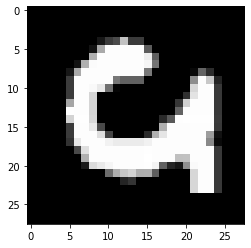

Predicted Label: 2, Correct Label 9


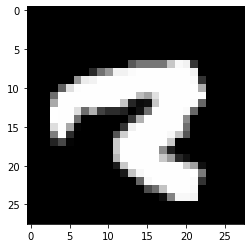

Predicted Label: 7, Correct Label 2


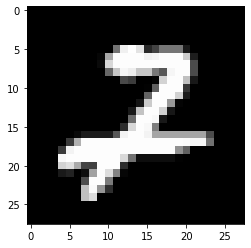

Predicted Label: 2, Correct Label 7


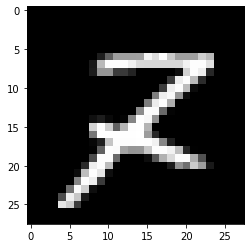

Predicted Label: 2, Correct Label 7


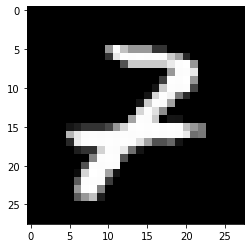

Predicted Label: 2, Correct Label 7


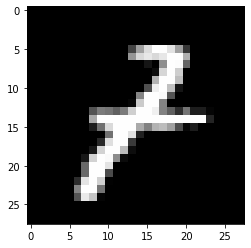

Predicted Label: 8, Correct Label 7


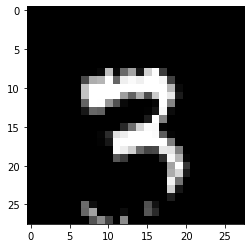

Predicted Label: 7, Correct Label 3


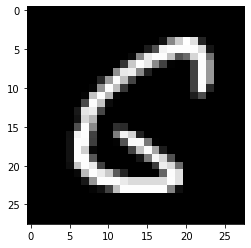

Predicted Label: 5, Correct Label 6


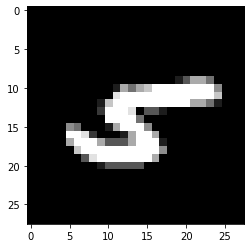

Predicted Label: 8, Correct Label 5


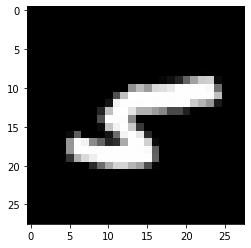

Predicted Label: 8, Correct Label 5


In [92]:
# so sehen 10 Bilder aus die falsch klassifiziert werden
for i in range(10):
    plt.imshow(test_images[falsche_klassifizierung[i]].reshape([28, 28]), cmap="gray")
    plt.show()
    print(
        "Predicted Label: %s, Correct Label %s"
        % (
            np.argmax(test_y_hat, axis=1)[falsche_klassifizierung[i]],
            test_labels[falsche_klassifizierung[i]],
        )
    )

Bei manchen Bilder können Sie klar sehen, warum diese falsch kategorisiert wurden. Bei anderen jedoch ist es für ein menschliches Auge ganz einfach die richtige Ziffer zuerkennen, trotzdem hat das Netzwerk damit Probleme.

Das war es für den ersten Tag. Wenn Sie wollen, könnem Sie noch mit den Hyperparameter spielen um Ihr Netzwerk zu verbessern.

In [100]:
np.random.seed(1234)
W, b = init_weights(784, 10000, 10)
loss= []
EPOCHS= 50 # wie oft der Datensatz durch das Netzwerk geführt wird
for i in range(EPOCHS):
    Z_1, A_1, Y_hat = forward_pass(W, b,train_images)
    
    loss= calc_loss(Y_hat, train_targets) / Y_hat.shape[0]
    
    acc = accuracy(train_labels, Y_hat)
    _, _, test_y_hat = forward_pass(W, b, test_images) # durch das _,_,test_y_hat werden z_1 und a_1 nicht mit ausgegeben, da wir diese nicht brauchen
    test_acc = accuracy(test_labels, test_y_hat) 
    
    print(
        "Training Loss: %.2f Training Accuracy: %.2f Test Accuarcy: %.2f"
        % (loss, acc, test_acc)
    )
    
    # wir machen die backpropagation
    grad_W, grad_b = back_prop(train_images, Z_1, A_1, Y_hat, train_targets)
    # und mit den Gradienten updaten wir die Weights
    W, b = update(W, b, grad_W, grad_b, lr = 0.1 )
    

Training Loss: 2.52 Training Accuracy: 0.08 Test Accuarcy: 0.08
Training Loss: 1.99 Training Accuracy: 0.33 Test Accuarcy: 0.34
Training Loss: 1.58 Training Accuracy: 0.47 Test Accuarcy: 0.47
Training Loss: 1.43 Training Accuracy: 0.60 Test Accuarcy: 0.60
Training Loss: 1.13 Training Accuracy: 0.67 Test Accuarcy: 0.68
Training Loss: 1.03 Training Accuracy: 0.72 Test Accuarcy: 0.72
Training Loss: 0.95 Training Accuracy: 0.74 Test Accuarcy: 0.75
Training Loss: 0.86 Training Accuracy: 0.76 Test Accuarcy: 0.77
Training Loss: 0.85 Training Accuracy: 0.77 Test Accuarcy: 0.77
Training Loss: 0.78 Training Accuracy: 0.78 Test Accuarcy: 0.79
Training Loss: 0.76 Training Accuracy: 0.79 Test Accuarcy: 0.80
Training Loss: 0.72 Training Accuracy: 0.80 Test Accuarcy: 0.81
Training Loss: 0.70 Training Accuracy: 0.81 Test Accuarcy: 0.82
Training Loss: 0.67 Training Accuracy: 0.82 Test Accuarcy: 0.83
Training Loss: 0.65 Training Accuracy: 0.83 Test Accuarcy: 0.84
Training Loss: 0.63 Training Accuracy: 0